# NYC restaurant data

my ongoing project in understanding NYC restaurant data
I would like to see how violations happen across the city, if there is something interesting there
Using this data set to learn exploration etc. 


I am interested in looking how the grades change over time. One of the first ideas I got was to aggregate all the grades in each month and plot that. 
I expect the number of grades to increase, and hopefully more As than any other grade, indicating that since 2011 Restaurants in NYC have conformed more to the cleanliness standards.

https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59

#### To Do:
+ see how the grades were awarded
+ what is required to get an A vs. any other grade
    + meaning what is the maximum number/type of violation to still receive an A 

In [40]:
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

import ggplot

In [2]:
start = dt.datetime.now()
nydata = pd.read_csv('NYC_Resto.csv')

print "the loading took {} seconds ".format((dt.datetime.now()-start).seconds)

the loading took 3 seconds 


### Some Data cleaning
+ remove unnecessary columns
+ remove 'Missing' values from the BORO column
+ remove 'Null' grades 
+ rename columns (temp) 
+ new DataFrame: **dates**

In [3]:
# unnecessary columns
nydata = nydata.drop(['CAMIS','PHONE','ZIPCODE','STREET', 'BUILDING','RECORD DATE'], axis=1)
# 'Missing' Boros
nydata = nydata[nydata['BORO']!='Missing']
# Null Grades
full_grade=pd.notnull(nydata['GRADE'])
nydata=nydata[full_grade]
nydata['BORO'].value_counts()

MANHATTAN        84447
BROOKLYN         50509
QUEENS           49912
BRONX            19654
STATEN ISLAND     7186
Name: BORO, dtype: int64

In [4]:
#rename columns, no spaces (this is convenient, we might get rid of it later)
nydata.columns=[c.replace(' ','_') for c in nydata.columns]

### change month to full name in 'INSPECTION_DATE'
+ smaller DataFrame with just dates and grades
+ change the 'INSPECTION DATE" to datetime (core numpy datatype which supports datetime functionality, **datetime64 dtype**)
+ also change index to **'INSPECTION DATE'**
+ change index to print out year and month name only

In [5]:
#dates.index=dates.INSPECTION_DATE
start = dt.datetime.now()
dates = nydata[['INSPECTION_DATE','GRADE_DATE','GRADE']]
dates.index =pd.to_datetime(nydata['INSPECTION_DATE'])
print "this took {} seconds".format((dt.datetime.now()-start).seconds)
#this takes a while

this took 69 seconds


In [7]:
#rename to month name
dates = dates.rename(index=lambda x:x.strftime('%Y-%B'))
# and here we leave off the day (?) 

In [8]:
dates=dates[['GRADE_DATE', 'GRADE']]
dates[:3]

,GRADE_DATE,GRADE
INSPECTION_DATE,,
2015-February,02/04/2015,A
2015-February,02/09/2015,A
2014-August,08/16/2014,A


In [9]:
#Now sort it by date CHECK WHAT THE RANGE OF DATES IS? 
dates = dates.sort_index(axis=0)
dates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211708 entries, 2011-July to 2016-May
Data columns (total 2 columns):
GRADE_DATE    210049 non-null object
GRADE         211708 non-null object
dtypes: object(2)
memory usage: 4.8+ MB


### Remove 'Not Yet Graded' ~ defeats the purpose of plotting grades
( there are about ~1600 'Not Yet Graded' but that's ok) 
**I want to plot A-Grades as function of time**

1. what are the ranges of dates that are available?
2. plot how many A's, B's etc. were awarded every month
3. need to bin data into months

In [10]:
dates=dates[dates['GRADE']!='Not Yet Graded']

### Divide dataframes by Grade, groupby INSPECTION_DATE to get a time  relationship
+ want how many of each of the grades were awarded in each month during the time period

In [11]:
dates['GRADE'][-5:]

INSPECTION_DATE
2016-May    A
2016-May    A
2016-May    A
2016-May    B
2016-May    B
Name: GRADE, dtype: object

In [25]:
#CALCULATE  ALL THE GRADES IN EACH MONTH
def get_grade_count_month(gradestring):
    # get the count of the grade in each month
    tmp_grade = dates[dates['GRADE']==gradestring][['GRADE']]
    # group by date: DATE IS IN INDEX
    grouped_tmp = tmp_grade.groupby(tmp_grade.index)
    return grouped_tmp.count()

# count up the grades in each month
grades_a = get_grade_count_month('A')
grades_b = get_grade_count_month('B')
grades_c = get_grade_count_month('C')
grades_p = get_grade_count_month('P')
grades_z = get_grade_count_month('Z')

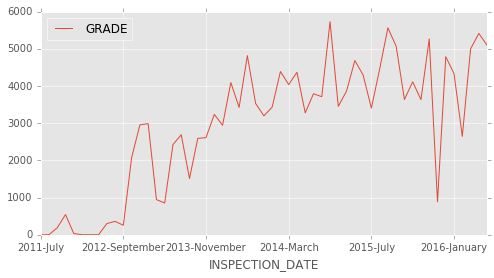

In [37]:
# test plots
matplotlib.style.use('ggplot')
grades_a.plot(figsize=(8,4), label='A grades')
plt.legend(loc='upper left')
#grades_b.plot()

# scaling

In [87]:
#from sklearn import preprocessing
grades_a_Scaled = preprocessing.scale(grades_a, with_mean=False)

#add as a column to grades_a
grades_a['scaled'] = grades_a_Scaled

In [88]:
grades_a[:3]

,GRADE,scaled
INSPECTION_DATE,,
2011-July,1,0.000569
2011-October,2,0.001137
2012-August,188,0.106908


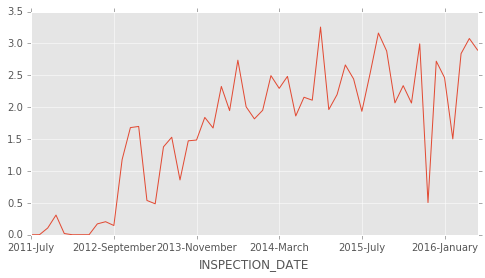

In [89]:
grades_a['scaled'].plot(figsize=(8,4))

+ to place data above zero?  (centers around 0, this is not actually what we want); set with_mean=False
+ can we do something else to it? 
## Normalization
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer
and
http://scikit-learn.org/stable/modules/preprocessing.html#normalization
+ for some reason have problem adding more than one column to data frame
+ ** HAD TO DELETE 'SCALED' FOR NOW ** 
+ figure this out later 

In [98]:
#from sklearn import preprocessing
grades_a_Norm = preprocessing.normalize(grades_a, norm='l1')   # try L2 and L1

# add to grades_a
grades_a['norm']= grades_a_Norm
#grades_a_Norm.shape

In [100]:
#del grades_a['norm']
#del grades_a['scaled']
grades_a[:3]


,GRADE,norm
INSPECTION_DATE,,
2011-July,1,0.500000
2011-October,2,0.666667
2012-August,188,0.994709


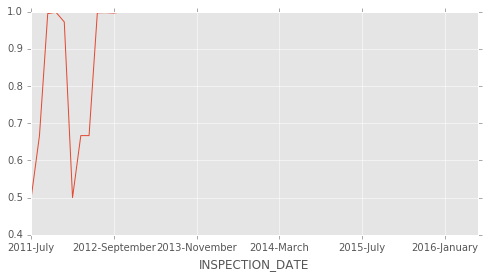

In [101]:
grades_a['norm'].plot(figsize=(8,4))

ok, well at this point I'm not sure what to do

It appears as though the number of A-grades awarded to all restaurants is increasing over time. It might be a good idea to get a smoother curve though 
Things I could do to fix this: 
+ group the data every two months ? 
+ rather than the number, show this data as the fraction/percentage of all awarded grades? 

#### issues with grade quantity comparison
It is also obvious that far more grades were awarded from September 2012. Without some Normalization or Standardization on the data, it makes no sense to compare the early data to the later one

In [43]:
#nydata=nydata.sort_index(axis=0)
#nydata[['INSPECTION_DATE', 'GRADE']].sort_values('INSPECTION_DATE', ascending=True)

+ used groupby.describe() to see summaries of various stats
#### TOTAL NUMBER of Grades, per month

In [38]:
# find out the TOTAL NUMBER OF GRADES in each month
grouped_total=dates[['GRADE']].groupby(dates.index)#.describe()
grade_total= grouped_total.count()
#grouped_total.describe()[:5]

In [33]:
## CALCULATE as fraction of total
def grade_percent(grade_count):
    return (grade_count/grade_total)*100

grades_a_time = grade_percent(grades_a)
#grades_b_time = grade_percent(grouped_b.count())
grades_c_time = grade_percent(grades_c)
#grades_p_time = grade_percent(grouped_p.count())
#grades_z_time = grade_percent(grouped_a.count())

#data = {'A':grades_a_time.values, 'B':grades_b_time.values , 'C':grades_c_time.values,
#        'Z':grades_z_time.values,
#     'P':grades_p_time.values} 
#df = pd.DataFrame(data, index=column)

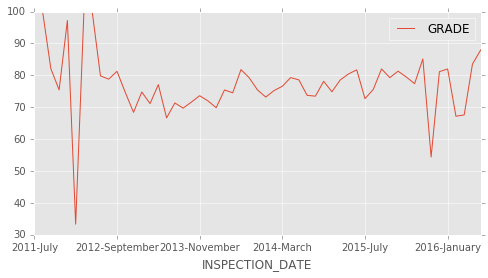

In [34]:
grades_a_time.plot(figsize=(8,4))

## before continuing, I need to do some standardization/normalization on my data
grades_a is how many A's there are in each month


In [43]:
grades_a_time.values;

In [52]:
column = grades_a_time.index.values

In [60]:
grades_a_time.dtypes

GRADE    float64
dtype: object

#### PLOTTING ISSUES AGAIN
 **ax1.plot(grades_a_time) # need to make sure all in floats ** << does not work 
 I get a value error ValueError: invalid literal for float():

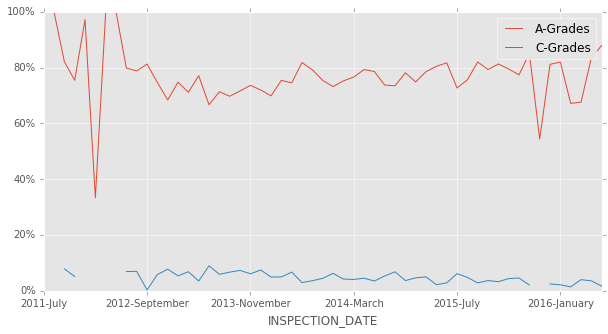

In [36]:
import matplotlib.ticker as mtick

matplotlib.style.use('ggplot')

#### put on same plot? 

#for i in range(2):
    #create a matplotlib figure instance; # FIG IS AN OBJECT
fig = plt.figure() #size=(10,5)
    #this object's add_subplot method is then called for every plotting window
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
    
    #get your ax from here ### PLOT
grades_a_time.plot(ax=ax1,figsize=(10,5)) 
grades_c_time.plot(ax=ax2)
    #ax1.plot(grades_a_time) # need to make sure all in floats


plt.legend(['A-Grades', 'C-Grades'], loc='upper right')#,labels="A-Grades")

#%format yticks as percentages 
fmt= '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)


In [ ]:
# grades_z_time.plot(figsize=(10,5))
#grades_p_time.plot(figsize=(10,5))

### observations on plot A
+ decem. 2013 are about the same % pointss as Aug.2015
+ 

1. it looks like at the beginning there are only A grades, maybe not enough grades assigned
2. some B and C grades might have to be interpolated  -- have to interpolate
3. What is grade 'Z' and 'P'? if I knnow this it might be helpful in figuring out if I wanna keep it 

another issue that should be looked it is how to handle the first couple of data in 2011. since only A's were awarded it's not very illuminating.
What if I divide everything out by the average?  Would this change anything? 

In [29]:
grades_a_time[-10:]

,GRADE
INSPECTION_DATE,
2015-October,4113
2015-September,3633
2016-April,5266
2016-August,889
2016-February,4787
2016-January,4333
2016-July,2645
2016-June,4996
2016-March,5413


In [ ]:
# not sure why this... 

a1=[]
for a in grades_a_time.values:
    a1.append(a)
    #print " iterator is ", a
    #type(a)
#b1=[]
#for b in grades_b_time.values:
    #b1.append(b)    
#data1 = {'A':a1, 'B':b1}
#df = pd.DataFrame(data, index=column)
a1;